## Facies classification using Random Forest


### Contest entry by <a href="https://geolern.github.io/index.html#">geoLEARN</a>:

##### <a href="https://github.com/mablou">Martin Blouin</a>,  <a href="https://github.com/lperozzi">Lorenzo Perozzi</a> and <a href="https://github.com/Antoine-Cate">Antoine Caté</a> <br>
in collaboration with Erwan Gloaguen

####  [Original contest notebook](../Facies_classification.ipynb) by Brendon Hall, [Enthought](https://www.enthought.com/)


In this notebook we will train a machine learning algorithm to predict facies from well log data.  The dataset comes from a class exercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011). 

The dataset consists of log data from nine wells that have been labeled with a facies type based on observation of core. We will use this log data to train a support vector machine to classify facies types.

## Original approach

- We focus on feature engineering instead of focus on algorithm optimization.
- The prediciton approach has been split in two steps. 1) try to predict non-marine facies; 2) try to predict marine facies. 
Validation scoring has been computed after the prediction results of the two approach have been stacked together.

#### Print the versions of  the used packages

In [28]:
%matplotlib inline
# to install watermark magic command: pip install ipyext
%load_ext watermark 
%watermark -v -p numpy,scipy,pandas,matplotlib,seaborn,sklearn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.5.2
IPython 5.1.0

numpy 1.11.1
scipy 0.18.0
pandas 0.18.1
matplotlib 1.5.1
seaborn 0.7.1
sklearn 0.18


### Exploring the dataset

First, we will examine the data set we will use to train the classifier.

In [29]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import preprocessing

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

# turn off ipython warnings 
import warnings
warnings.filterwarnings('ignore')

filename = '../facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,NaN,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,NaN,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,NaN,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Let's clean up this dataset.  The 'Well Name' and 'Formation' columns can be turned into a categorical data type.

In [30]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

These are the names of the 10 training wells in the Council Grove reservoir. Data has been recruited into pseudo-well 'Recruit F9' to better represent facies 9, the Phylloid-algal bafflestone.

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this tutorial. We also create the abbreviated facies labels, and add those to the facies_vectors dataframe.

In [31]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,NaN,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,NaN,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,NaN,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


#### We group the dataset by well name to add variables well by well

In [32]:
grouped = training_data.groupby(['Well Name'])

#### We build a function to create new variables representing the absolute distance of a deposit to an upper marine context (younger) and one for the distance to a deeper marine context (older)

In [33]:
def make_dist_mar_vars(wells_df):
 
    grouped = wells_df.groupby(['Well Name'])
    new_df = pd.DataFrame()
    
    for key in grouped.groups.keys():
    
        NM_M = grouped.get_group(key)['NM_M'].values

        #We create a temporary dataframe that we reset for every well
        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        temp_df['Well Name'] = [key for _ in range(len(NM_M))]

        #We initialize new variables
        dist_mar_up = np.zeros(len(NM_M))
        dist_mar_down = np.zeros(len(NM_M))

        # A variable counting the interval from the upper marine deposit an one for bottom lower deposit
        # We initialize them to -99999 since we do not know what's above the first log
        count = -99999
        
        #we build them in two seperate loops
        for i in range(len(NM_M)):

            if ((NM_M[i] == 1) & (count>-99999)):

                count+=0.5
                dist_mar_up[i] += count

            elif NM_M[i] == 2:

                count=0

            else:
                dist_mar_up[i] = count

        #********************************************#
        #we reset count
        count = -99999
        
        for i in range(len(NM_M)-1,-1,-1):
               
            if ((NM_M[i] == 1) & (count>-99999)):

                count+=0.5
                dist_mar_down[i] += count

            elif NM_M[i] == 2:            
                count=0

            else:
                dist_mar_down[i] = count
                
        #********************************************#       

        temp_df['dist_mar_up'] = dist_mar_up
        temp_df['dist_mar_down'] = dist_mar_down
    
        # We append each well variable to a larger dataframe
        # We use a dataframe to preserve the index
        new_df = new_df.append(temp_df) 
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    
    #We don't use merge as it creates duplicates for curious reasons that we later have to drop
    return pd.concat([wells_df,new_df],axis=1)

training_data = make_dist_mar_vars(training_data)
training_data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels,dist_mar_up,dist_mar_down
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS,-99999.0,21.5
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS,-99999.0,21.0
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS,-99999.0,20.5
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS,-99999.0,20.0
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS,-99999.0,19.5


#### Encoding Formation labels
Formation labes are encoded as integer values

In [34]:
LE = preprocessing.LabelEncoder()
training_data['Formation_category'] = LE.fit_transform(training_data.Formation)

#### Let's see how well NM_M variable discriminates facies

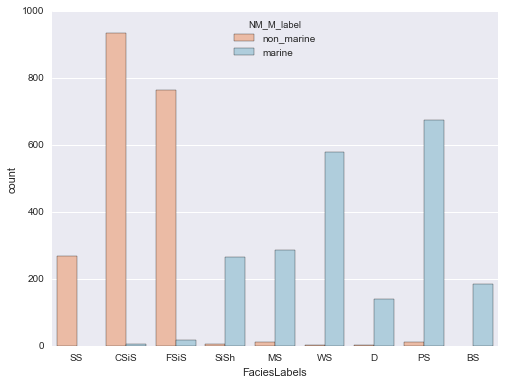

In [35]:
import seaborn as sns
training_data['NM_M_label'] = training_data['NM_M'].apply(lambda x: 'non_marine' if x == 1 else 'marine')

plt.figure(figsize=(8,6))

sns.countplot(x="FaciesLabels", hue="NM_M_label", 
              order=['SS', 'CSiS', 'FSiS', 'SiSh','MS','WS','D','PS','BS'], 
              data=training_data, palette = "RdBu");

Now, as the NM_M variable classify fairly well the facies, we assume that facies 1-3 (`SS to FSiS`) are non marine and facies 4-9 (`SiSh to BS`) are marine. 

In [36]:
training_data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels,dist_mar_up,dist_mar_down,Formation_category,NM_M_label
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS,-99999.0,21.5,1,non_marine
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS,-99999.0,21.0,1,non_marine
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS,-99999.0,20.5,1,non_marine
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS,-99999.0,20.0,1,non_marine
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS,-99999.0,19.5,1,non_marine


In [37]:
training_data = training_data.drop(['NM_M_label','FaciesLabels'], axis=1)
NM_training_data = training_data[training_data['NM_M'] == 1]
M_training_data = training_data[training_data['NM_M'] == 2]

Instead of drop the `NaN` associated with PE we decided to replace with an 'out of the range' value (i.e. -99999). This allow the classifier to take into account the data associated with the `NaN` of PE, for the others variables

In [38]:
NM_training_data.replace(to_replace=np.nan,value=-99999,inplace=True)
M_training_data.replace(to_replace=np.nan,value=-99999,inplace=True)

#### We drop unused variables for marine and non-marine dataset (we prepare the list here)

In [41]:
nm_drop_list = ['Formation', 'Well Name', 'Depth', 
                'Facies','DeltaPHI','PE','NM_M','RELPOS']

m_drop_list = ['Formation', 'Well Name', 'Depth', 
               'Facies','dist_mar_down','dist_mar_up','PE','NM_M','PHIND']

In [42]:
from sklearn import ensemble
from sklearn import metrics
clf = ensemble.RandomForestClassifier(n_estimators=500,n_jobs=-1)

for _ in range(1):
    names = list(np.unique(training_data['Well Name']))

    nm_grouped = NM_training_data.groupby(['Well Name'])
    m_grouped = M_training_data.groupby(['Well Name'])

    new_df = pd.DataFrame()

    scores = []

    for name in names:

        temp_df = pd.DataFrame()

        # We need to isolate Recruit F9 since it has only marine facies
        if name == 'Recruit F9':

            #Build list of well names and remove blind well (and remove recruit F9 for NM)
            m_train_names = names.copy()
            m_train_names.remove(name)

            # Do it for marine sediments
            m_test = m_grouped.get_group(name)
            m_test_depth = m_test.Depth
            m_X_test = m_test.drop(m_drop_list, axis=1).values
            y_test = m_test['Facies'].values

            m_train = pd.DataFrame()

            for train_name in m_train_names:
                m_train = m_train.append(m_grouped.get_group(train_name))

            id_train_M = m_train.Facies >= 4
            m_train = m_train [id_train_M]
            m_X_train = m_train.drop(m_drop_list, axis=1).values
            m_y_train = m_train['Facies'].values

            #The prediction begins

            #We start with oversampling minority classes
#             m_X_train, m_y_train = smt.fit_sample(m_X_train,m_y_train)

            #Then we do random forest classification
            clf.fit(m_X_train, m_y_train)
            y_pred = clf.predict(m_X_test)

        else:

            #Build list of well names and remove blind well (and remove recruit F9 for NM)
            m_train_names = names.copy()
            m_train_names.remove(name)   

            nm_train_names = m_train_names.copy()
            nm_train_names.remove('Recruit F9')


            # Do it for non-marine sediments
            nm_test = nm_grouped.get_group(name)
            nm_test_depth = nm_test.Depth
            nm_X_test = nm_test.drop(nm_drop_list, axis=1).values
            nm_y_test = nm_test['Facies'].values

            nm_train = pd.DataFrame()

            for train_name in nm_train_names:
                nm_train = nm_train.append(nm_grouped.get_group(train_name))

            id_train_NM = nm_train.Facies <= 3
            nm_train = nm_train [id_train_NM]
            nm_X_train = nm_train.drop(nm_drop_list, axis=1).values
            nm_y_train = nm_train['Facies'].values

            #The prediction begins

            #We start with oversampling minority classes
#             nm_X_train, nm_y_train = smt.fit_sample(nm_X_train,nm_y_train)

            #Then we do random forest classification
            clf.fit(nm_X_train, nm_y_train)
            nm_y_pred = clf.predict(nm_X_test)

            print(clf.feature_importances_)

            #*********************************************************************#

            # Do it for marine sediments
            m_test = m_grouped.get_group(name)
            m_test_depth = m_test.Depth
            m_X_test = m_test.drop(m_drop_list, axis=1).values
            m_y_test = m_test['Facies'].values

            m_train = pd.DataFrame()

            for train_name in m_train_names:
                m_train = m_train.append(m_grouped.get_group(train_name))

            id_train_M = m_train.Facies >= 4
            m_train = m_train [id_train_M]
            m_X_train = m_train.drop(m_drop_list, axis=1).values
            m_y_train = m_train['Facies'].values

            #The prediction begins

            #We start with oversampling minority classes
#             m_X_train, m_y_train = smt.fit_sample(m_X_train,m_y_train)

            #Then we do random forest classification
            clf.fit(m_X_train, m_y_train)
            m_y_pred = clf.predict(m_X_test)

            print(clf.feature_importances_)

            #================================================================#
            #                         combine results
            #================================================================#

            y_test = np.hstack((nm_y_test,m_y_test))
            y_pred = np.hstack((nm_y_pred,m_y_pred))

        #Scoring
        conf_mat = metrics.confusion_matrix(y_test,y_pred)
        print(conf_mat)
        try:
            score = metrics.f1_score(y_test, y_pred,average='weighted')
        except:
            score = conf_mat[1,1]/np.sum(conf_mat)
        scores.append(score)
        print('********')
        print('Blind well is {0}, F1 score : {1:.4%}\n'.format(name,score))

        if name == 'Recruit F9':
            depth = m_test_depth
        else:
            depth = np.hstack((nm_test_depth,m_test_depth))

        idx = np.argsort(depth)
        temp_df['Depth'] = depth[idx]
        temp_df['True Facies'] = y_test[idx]
        temp_df['Predicted Facies'] = y_pred[idx]

        temp_df['Well Name'] = [name for _ in range(len(depth))]
        new_df = new_df.append(temp_df)

    print("="*30)
    print('*********** RESULT ***********')
    print("="*30)
    print('\nAverage  F1-score is {:.4%}'.format(np.mean(scores)))

[ 0.14781561  0.1912122   0.18272246  0.17855021  0.18726854  0.11243098]
[ 0.23812401  0.23601512  0.19850054  0.22319717  0.10416316]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0 97 20  0  0  0  0  0  0]
 [ 1 35 55  0  0  0  0  0  0]
 [ 0  0  0 35  0  1  2  6  0]
 [ 0  0  0  4  9  3  1  9  0]
 [ 0  0  0 14 13 12  7 23  0]
 [ 0  0  0  0  5  0 11  0  0]
 [ 0  0  0  5  7 15 18 47  6]
 [ 0  0  0  0  0  0  0  0  5]]
********
Blind well is ALEXANDER D, F1 score : 57.0553%

[ 0.154705    0.19152884  0.19443405  0.1742997   0.17884126  0.10619115]
[ 0.24592753  0.23190963  0.19757466  0.22710832  0.09747986]
[[ 0  4  4  0  0  0  0  0  0]
 [ 0 34 21  0  0  1  0  0  0]
 [ 0  6 38  0  0  4  0  3  0]
 [ 0  0  0  5  0  7  0  1  0]
 [ 0  0  1  1  7 16  0  5  0]
 [ 0  0  0  8  0 54  0 25  0]
 [ 0  0  1  0  0  1  0 25  7]
 [ 0  1  2  0  2 20  0 49  1]
 [ 0  0  0  0  0  0  0  0 50]]
********
Blind well is CHURCHMAN BIBLE, F1 score : 54.9622%

[ 0.16089071  0.15117278  0.22435554  0.17624543  0.19058438  0.0967

### Applying the classification model to new data

In [43]:
filename = '../validation_data_nofacies.csv'
test_data = pd.read_csv(filename)
test_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911
...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556


#### Create new variables for the test dataset
- we compute the absolute distance of a deposit to an upper marine context (younger) and one for the distance to a deeper marine context (older)
- we encode the formation category

In [44]:
# absoulte distance
test_data = make_dist_mar_vars(test_data)
# formation category encoding
test_data['Formation_category'] = LE.fit_transform(test_data.Formation)

#### We train our classifier to the entire available dataset (10 wells), keeping the separation between marine and non-marine sediments

In [45]:
#  nm = non-marine and m = marine
nm_drop_list = ['Formation', 'Well Name', 'Depth','DeltaPHI','PE',
                'NM_M','RELPOS']
m_drop_list = ['Formation', 'Well Name', 'Depth',
               'dist_mar_down','dist_mar_up','PE','NM_M','PHIND']

In [51]:
nm_test = test_data[test_data['NM_M'] == 1]
m_test = test_data[test_data['NM_M'] == 2]

#### Train and making prediction for the the well test

In [69]:
new_df = pd.DataFrame()

# Do it for non-marine sediments
nm_test_depth = nm_test.Depth
nm_X_test = nm_test.drop(nm_drop_list, axis=1).values

id_train_NM = NM_training_data.Facies <= 3


nm_train = NM_training_data[id_train_NM]

nm_X_train = nm_train.drop(nm_drop_list, axis=1)
nm_X_train = nm_X_train.drop('Facies', axis=1).values
nm_y_train = nm_train['Facies'].values

#Then we do random forest classification
clf.fit(nm_X_train, nm_y_train)
nm_y_pred = clf.predict(nm_X_test)

#*********************************************************************#

# Do it for marine sediments
m_test_depth = m_test.Depth
m_X_test = m_test.drop(m_drop_list, axis=1).values

id_train_M = M_training_data.Facies >= 4
m_train = M_training_data[id_train_M]

m_X_train = m_train.drop('Facies', axis=1)
m_X_train = m_X_train.drop(m_drop_list,axis=1).values
m_y_train = m_train['Facies'].values

#Then we do random forest classification
clf.fit(m_X_train, m_y_train)
m_y_pred = clf.predict(m_X_test)

#================================================================#
#                         combine results
#================================================================#

y_pred = np.hstack((nm_y_pred,m_y_pred))


depth = np.hstack((nm_test_depth,m_test_depth))
idx = np.argsort(depth)

new_df['Depth'] = depth[idx]
new_df['Predicted Facies'] = y_pred[idx]

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The code and ideas in this notebook,</span> by <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">geoLEARN,</span> are licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

In [70]:
new_df

,Depth,Predicted Facies
0,2808.0,2
1,2808.5,3
2,2809.0,3
3,2809.5,3
4,2810.0,3
...,...,...
825,3158.5,3
826,3159.0,3
827,3159.5,2
828,3160.0,2
